In [8]:
import numpy as np
import pandas as pd
from numba import njit,jit

def InflowRatio(input_vector:list)->float:
  normalized_radius,inflow_i,C_T_i,C_T_req,step_size = input_vector
  solidity = 0.1
  coefficient_lift_alpha = 2*np.pi
  first_term = solidity*coefficient_lift_alpha/16
  second_term = np.sqrt(1+(32/(solidity*coefficient_lift_alpha))*Twist(input_vector)*normalized_radius) - 1
  input_vector[1] = first_term*second_term
  return input_vector
def Twist(input_vector:list)->float:
  normalized_radius,inflow_i,C_T_i,C_T_req,step_size = input_vector
  solidity = 0.1
  coefficient_lift_alpha = 2*np.pi
  tip_twist = 4*C_T_req/(solidity*coefficient_lift_alpha) + inflow_i
  return tip_twist/normalized_radius

def DeltaCoefficientThrust(input_vector:list)->float:
  normalized_radius,inflow_i,C_T_i,C_T_req,step_size = input_vector
  solidity = 0.1
  coefficient_lift_alpha = 2*np.pi
  return (solidity*coefficient_lift_alpha/2)*(Twist(input_vector)*normalized_radius**2 - InflowRatio(input_vector)*normalized_radius)*step_size
def CoefficientThrustBEMT(input_vector:list)->float:
  normalized_radius,inflow_i,C_T_i,C_T_req,step_size = input_vector
  radius_values = np.arange(start=0.1,stop=1.0+step_size,step=step_size)
  print(np.sum([DeltaCoefficientThrust(input_vector) for input_vector[0] in radius_values]))
  input_vector[2] =  np.sum([DeltaCoefficientThrust(input_vector) for input_vector[0] in radius_values])
  return input_vector
C_T_req = 0.008
test_input = np.array([
  0.15,
  np.sqrt(C_T_req/2),
  C_T_req-0.001,
  C_T_req,
  1/100
])
print(test_input)
print(CoefficientThrustBEMT(test_input))

[0.15       0.06324555 0.007      0.008      0.01      ]
-0.030319078435139903
[ 1.          0.06324555 -0.03031908  0.008       0.01      ]


In [9]:
import numpy as np
def InflowRatio(normalized_radius, inflow_i, C_T_i, C_T_req, step_size):
    solidity = 0.1
    coefficient_lift_alpha = 2 * np.pi
    first_term = solidity * coefficient_lift_alpha / 16
    second_term = np.sqrt(1 + (32 / (solidity * coefficient_lift_alpha)) * Twist(normalized_radius, inflow_i, C_T_req) * normalized_radius) - 1
    return first_term * second_term
def Twist(normalized_radius, inflow_i, C_T_req):
    solidity = 0.1
    coefficient_lift_alpha = 2 * np.pi
    tip_twist = 4 * C_T_req / (solidity * coefficient_lift_alpha) + inflow_i
    return tip_twist / normalized_radius
def DeltaCoefficientThrust(normalized_radius, inflow_i, C_T_i, C_T_req, step_size):
    solidity = 0.1
    coefficient_lift_alpha = 2 * np.pi
    inflow_ratio = InflowRatio(normalized_radius, inflow_i, C_T_i, C_T_req, step_size)
    twist = Twist(normalized_radius, inflow_i, C_T_req)
    return (solidity * coefficient_lift_alpha / 2) * (twist * normalized_radius**2 - inflow_ratio * normalized_radius) * step_size
def CoefficientThrustBEMT(C_T_req, inflow_i, C_T_i, step_size):
    radius_values = np.arange(start=0.1, stop=1.0 + step_size, step=step_size)
    total_thrust = np.sum([
        DeltaCoefficientThrust(r, inflow_i, C_T_i, C_T_req, step_size)
        for r in radius_values
    ])
    return total_thrust

C_T_req = 0.008
test_input = {
    "normalized_radius": 0.5,
    "inflow_i": np.sqrt(0.0001 / 2),
    "C_T_i": C_T_req + 0.001,
    "C_T_req": C_T_req,
    "step_size": 1 / 1000,
}
test_result = CoefficientThrustBEMT(
    C_T_req=test_input["C_T_req"],
    inflow_i=test_input["inflow_i"],
    C_T_i=test_input["C_T_i"],
    step_size=test_input["step_size"]
)

print(f"Computed Coefficient of Thrust: {test_result}")


Computed Coefficient of Thrust: 0.0029866206465162227


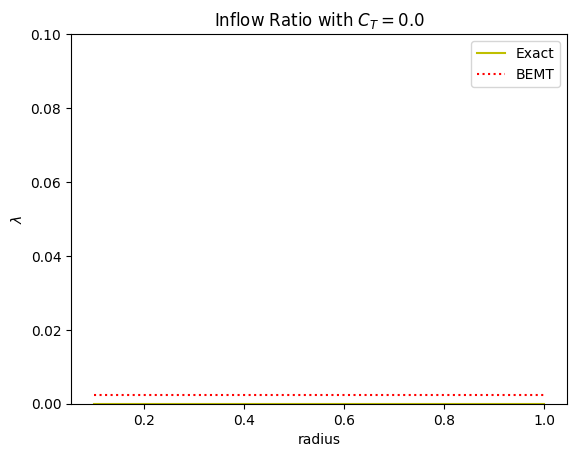

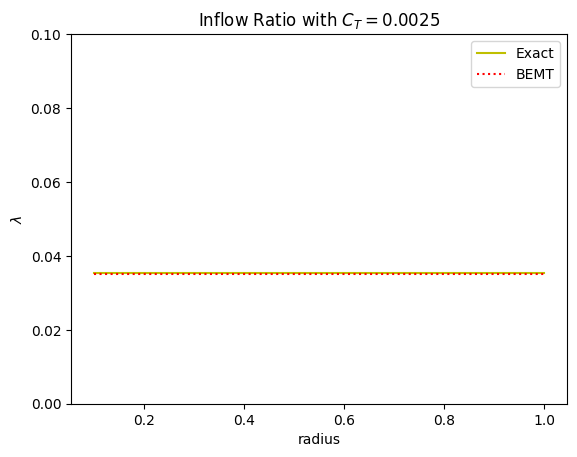

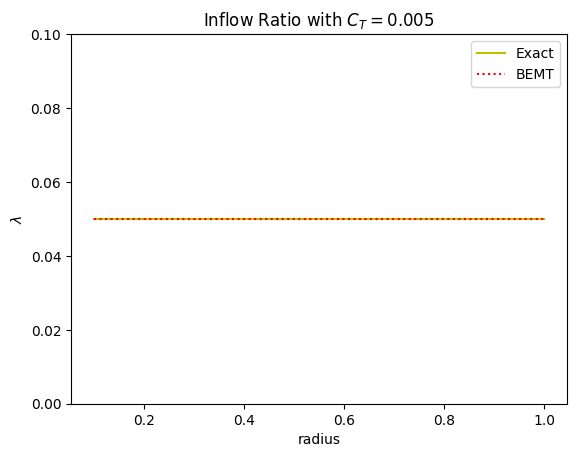

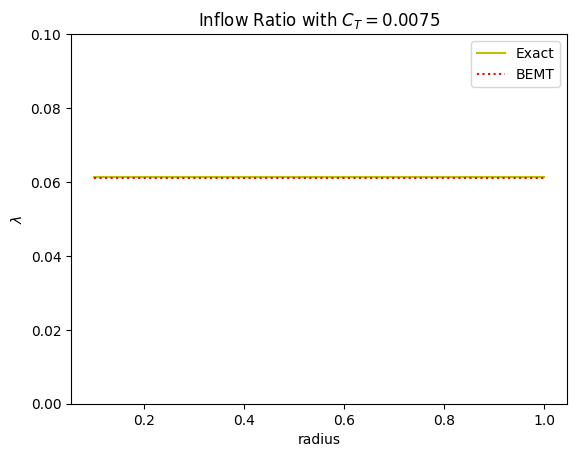

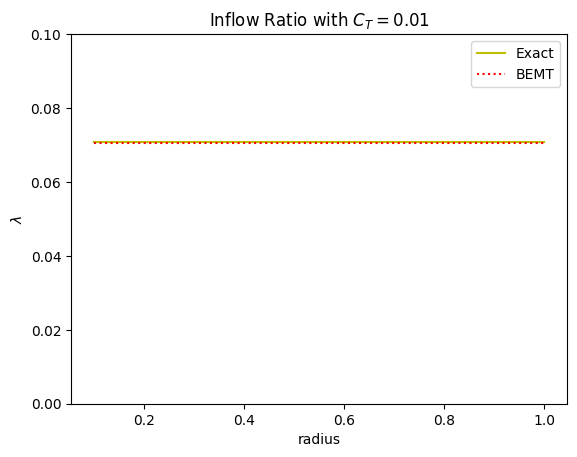

In [52]:
import matplotlib.pyplot as plt
def BEMT(C_T_reqired):
    tolerance = 1e-5
    input = {
        "normalized_radius": 0.5,
        "inflow_i": np.sqrt(0.001 / 2),
        "C_T_i": 1,
        "C_T_req": C_T_reqired,
        "step_size": 1 / 100,
    }
    radius_values = np.arange(
        start=0.1, stop=1.0 + input["step_size"], step=input["step_size"]
    )
    inflow_values = []
    C_T_values = []
    for r in radius_values:
        iteration_max = 100
        iteration_count = 0
        C_T_reqired = input["C_T_req"]
        input = {
            "normalized_radius": 0.5,
            "inflow_i": np.sqrt(0.001 / 2),
            "C_T_i": 1,
            "C_T_req": C_T_reqired,
            "step_size": 1 / 100,
        }
        C_T_numerical = CoefficientThrustBEMT(
            C_T_req=input["C_T_req"],
            inflow_i=input["inflow_i"],
            C_T_i=input["C_T_i"],
            step_size=input["step_size"],
        )
    
        while abs(C_T_reqired - C_T_numerical) >= tolerance:
            iteration_count += 1
            if iteration_count >= iteration_max:
                # print("Failed to converge for CT =", C_T_numerical)
                break
        
            # Update inflow_i and recompute C_T_numerical
            input["inflow_i"] = InflowRatio(
                r,
                input["inflow_i"],
                input["C_T_i"],
                input["C_T_req"],
                input["step_size"],
            )
            C_T_numerical = CoefficientThrustBEMT(
                C_T_req=input["C_T_req"],
                inflow_i=input["inflow_i"],
                C_T_i=input["C_T_i"],
                step_size=input["step_size"],
            )
            # Update C_T_i for the next iteration
            input["C_T_i"] = C_T_numerical
    
        # print(f"Converged for r = {r} with input: {input}")
        inflow_values.append(input['inflow_i'])
        C_T_values.append(input["C_T_i"])
    return [inflow_values,C_T_values]
for C_T_req in np.linspace(0.0,0.01,5):
    inflow_bemt,CT_bemt = BEMT(C_T_req)[:][:]
    # print(CT_bemt)
    inflow_exact = np.full(len(inflow_bemt),np.sqrt(C_T_req/2))
    radius_values = np.arange(start=0.1, stop=1.0 + 1/100, step=1/100)
    plt.plot(radius_values,inflow_exact,label='Exact',color='y')
    plt.plot(radius_values,inflow_bemt,label='BEMT',linestyle=':',color='r')
    plt.xlabel('radius')
    plt.ylabel(r'$\lambda$')
    plt.title(r'Inflow Ratio with $C_T={}$'.format(C_T_req))
    plt.ylim(0.0,0.1)
    plt.legend()
    plt.show()